In [166]:
#Importing libraries
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import numpy as np
import sdt.changepoint as c
import math

In [167]:
#import ARIMA libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import numpy as np

In [168]:
# create a dataframe from the csv file
df_new_cases = pd.read_csv('../data/WHO-COVID-19-global-data.csv')
#df_vaccination = pd.read_csv('../data/owid-covid-data.csv')
df_vaccination = pd.read_csv('../data/country_vaccinations.csv')

In [169]:
# add moving average for new cases
#df_vaccination['moving_average_new_vaccinations'] = df_vaccination.groupby('iso_code')['new_vaccinations'].transform(lambda x: x.rolling(window=7).mean()) # OWID
df_vaccination['moving_average_new_vaccinations'] = df_vaccination.groupby('iso_code')['daily_vaccinations'].transform(lambda x: x.rolling(window=7).mean())

# rimuovi tutte le righe che non hanno un valore o hanno un valore a "0.0" per moving_average_new_cases
df_vaccination = df_vaccination.dropna(subset=['moving_average_new_vaccinations'])
df_vaccination = df_vaccination[df_vaccination['moving_average_new_vaccinations'] != 0.0]

In [170]:
# add moving average for new cases
df_new_cases['moving_average_new_cases'] = df_new_cases.groupby('Country_code')['New_cases'].transform(lambda x: x.rolling(window=7).mean())

# rimuovi tutte le righe che non hanno un valore o hanno un valore a "0.0" per moving_average_new_cases
df_new_cases = df_new_cases.dropna(subset=['moving_average_new_cases'])
df_new_cases = df_new_cases[df_new_cases['moving_average_new_cases'] != 0.0]

In [171]:
# firter data from 2021-07-16 to 2021-08-15
start_date = date(2021, 7, 7) 
og_start_date = date(2021, 7, 22)
og_end_date = date(2021, 8, 8)
end_date = date(2021, 8, 31)

difference = og_start_date - start_date
event_duration = og_end_date - og_start_date

# filter data from 2021-07-16 to 2021-08-15
df_new_cases = df_new_cases[(df_new_cases['Date_reported'] >= str(start_date)) & (df_new_cases['Date_reported'] <= str(end_date))]

# filter df_vaccination from 2021-07-16 to 2021-08-15
df_vaccination = df_vaccination[(df_vaccination['date'] >= str(start_date)) & (df_vaccination['date'] <= str(end_date))]

In [172]:
#filter by iso_cod that not contain "OWID" prefix
df_vaccination = df_vaccination[~df_vaccination['iso_code'].str.contains("OWID")]

# aggragate by iso_code and date and sum total_cases, total_deaths, population, total_vaccinations, new_cases, mind positive_rate, max positive_rate,KEEP LOCATION 
#df_vaccination = df_vaccination.groupby(['iso_code', 'date']).agg({'people_vaccinated':'sum', 'new_vaccinations': 'sum', 'location': 'max', 'moving_average_new_vaccinations': 'sum'})
df_vaccination = df_vaccination.groupby(['iso_code', 'date']).agg({'total_vaccinations':'sum', 'daily_vaccinations': 'sum', 'country': 'max', 'moving_average_new_vaccinations': 'sum'})

In [173]:
# save dataframe in csv file
df_new_cases.to_csv('./dataframe.csv')
df_vaccination.to_csv('./vaccinations.csv')

In [174]:
'''for iso_code in df_vaccination.index.get_level_values('iso_code').unique():
    plt.plot(df_vaccination.loc[iso_code]['moving_average_new_vaccinations'], label='vaccinations')
    plt.title(df_vaccination.loc[iso_code]['country'].unique()[0])
    plt.ylabel("new vaccinations")
    plt.xlabel("Date")
    plt.xticks(rotation=90)
    plt.show()'''

'for iso_code in df_vaccination.index.get_level_values(\'iso_code\').unique():\n    plt.plot(df_vaccination.loc[iso_code][\'moving_average_new_vaccinations\'], label=\'vaccinations\')\n    plt.title(df_vaccination.loc[iso_code][\'country\'].unique()[0])\n    plt.ylabel("new vaccinations")\n    plt.xlabel("Date")\n    plt.xticks(rotation=90)\n    plt.show()'

In [175]:
# aggragate by iso_code and date and sum total_cases, total_deaths, population, total_vaccinations, new_cases, mind positive_rate, max positive_rate,KEEP LOCATION 
df_new_cases = df_new_cases.groupby(['Country_code', 'Date_reported']).agg({'Country': 'sum', 'WHO_region': 'sum', 'New_cases': 'sum', 'Cumulative_cases': 'sum', 'New_deaths': 'sum', 'Cumulative_deaths': 'sum', 'moving_average_new_cases': 'sum'})

In [176]:

all_iso_codes = df_new_cases.index.get_level_values('Country_code').unique()

In [177]:
# use ARIMA show how was the prediction of new cases during the Olympic Games with the data of the previous start of olimpic games considering the progress of vaccination


TypeError: expected non-empty vector for x

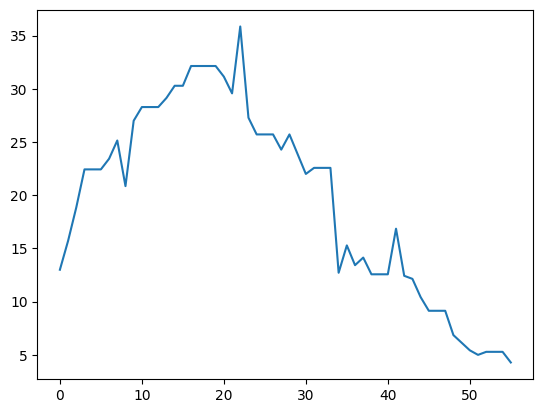

In [178]:
#interval technique
BayesOffline = c.BayesOffline()
media_changepoint = 0.0
count_changepoint = 0.0
min_changepoint = (999,"error")
max_changepoint = (-1,"error")
save_me = []
tabella2 = pd.DataFrame(columns=['State','FirstSlope','SecondSlope','ThirdSlope','FourthSlope'])
trend_negative = []
trend_positive = []

for code in all_iso_codes:
    # Out is a list of possible changepoint "indices"
    values = df_new_cases.loc[code]['moving_average_new_cases'].values
    prob = 0.9
    out = []
    plot_out = []
    
    
    df2 = df_new_cases.loc[code]['moving_average_new_cases']
    # Questa riga estrae i valori della colonna "Data" del dataframe df dalla prima data del dataframe alla data del lockdown.
    values_before = df2.iloc[:difference.days+1].values
    # Questa riga estrae i valori della colonna "Data" del dataframe df dalla data del lockdown fino alla settimana successiva 4.
    values_oneWeek = df2.iloc[difference.days:difference.days+event_duration.days].values
    # Questa riga estrae i valori della colonna "Data" del dataframe df dalla data del lockdown fino alla settimana successiva 5.
    values_twoWeek = df2.iloc[difference.days+event_duration.days:difference.days+15].values
    # Questa riga estrae i valori della colonna "Data" del dataframe df dalla data del lockdown fino alla settimana successiva 6.
    values_after = df2.iloc[difference.days+15:].values
    
    while len(out) == 0:
        prob = prob * 0.9
        out = BayesOffline.find_changepoints(values, prob_threshold=prob)
    
    #print("OUT", out, 'VALUES', values)
    # Plot the data.
    c.plot_changepoints(values, out, segment_alpha=0,segment_colors=['#66ffc2', '#ffb3b3']) #here it's used just to plot the initial graph, easier than doing it manually


    z1 = np.polyfit(range(0,len(values_before)), values_before, 1)
    #print ("{0}x + {1}".format(*z1))
    p1 = np.poly1d(z1)
    z2 = np.polyfit(range(len(values_before),len(values_before)+len(values_oneWeek)), values_oneWeek, 1)
    p2 = np.poly1d(z2)
    z3 = np.polyfit(range(len(values_before)+len(values_oneWeek),len(values_before)+len(values_oneWeek)+len(values_twoWeek)), values_twoWeek, 1)
    p3 = np.poly1d(z3)
    z4 = np.polyfit(range(len(values_before)+len(values_oneWeek)+len(values_twoWeek),len(values_before)+len(values_oneWeek)+len(values_twoWeek)+len(values_after)), values_after, 1)
    p4 = np.poly1d(z4)
    
    entry = pd.DataFrame.from_dict({"State": code,'FirstSlope': [z1[0]],'SecondSlope': [z2[0]],'ThirdSlope': [z3[0]],'FourthSlope': [z4[0]]})
    tabella2 = pd.concat([tabella2, entry], ignore_index=True)

    array1 = np.arange(0,len(values_before))
    array2 = np.arange(len(values_before),len(values_before)+len(values_oneWeek))
    array2 = np.insert(array2, 0, array1[-1])
    array3 = np.arange(len(values_before)+len(values_oneWeek),len(values_before)+len(values_oneWeek)+len(values_twoWeek))
    array3 = np.insert(array3, 0, array2[-1])
    array4 = np.arange(len(values_before)+len(values_oneWeek)+len(values_twoWeek),len(values_before)+len(values_oneWeek)+len(values_twoWeek)+len(values_after))
    array4 = np.insert(array4, 0, array3[-1])
    lw = 2
    

    plt.plot(array1, p1(range(0,len(values_before))), color="#0B1F65", linewidth=lw, linestyle="dashdot")
    plt.plot(array2, p2(range(len(values_before)-1,len(values_before)+len(values_oneWeek))), color="#116530", linewidth=lw, linestyle="dashdot")
    plt.plot(array3, p3(range(len(values_before)+len(values_oneWeek)-1,len(values_before)+len(values_oneWeek)+len(values_twoWeek))), color="#D7A449", linewidth=lw, linestyle="dashdot")
    plt.plot(array4, p4(range(len(values_before)+len(values_oneWeek)+len(values_twoWeek)-1,len(values_before)+len(values_oneWeek)+len(values_twoWeek)+len(values_after))), color="#DB3F29", linewidth=lw, linestyle="dashdot")

    # Crea un plot con i punti di cambio colorati
    plt.title(code + " - " + df_new_cases.loc[code]['Country'].unique()[0])
    plt.axvline(x = difference.days-14, color = 'blue', label = '14 days before first game of olympic games')
    plt.axvline(x = difference.days+7, color = 'orange', label = '7 days after first game of olympic games')
    plt.axvline(x = difference.days+18, color = '#FF7D4D', label = '7 days after last game of olympic games')
    plt.xlabel("Days since the 28th of July 2021")
    plt.ylabel("Current MA - Previous MA")
    #plt.legend()
    plt.axvspan(difference.days, difference.days+11, facecolor='#ffe206', alpha=0.5)
    ymax = plt.ylim()[1]
    # aggiungi un margine di 5% sopra il massimo valore per far spazio alle etichette
    plt.ylim(ymax=ymax*1.20)
    plt.text(difference.days-14, ymax, "14 days before\nfirst game of\nolympic games", rotation=0, color="white", backgroundcolor="blue")
    plt.text(difference.days, ymax, "Olympic \nGames", rotation=0, color="black", backgroundcolor="yellow")
    plt.text(difference.days+7+1, ymax, "7 days \nafter first metch", rotation=0, backgroundcolor="orange")
    plt.text(difference.days+18+1, ymax, "7 days \nafter last match", rotation=0, backgroundcolor="#FF7D4D")
    #save the plot as a png file
    plt.savefig("../pictures/"+ code + "_intervals" +".png")
    plt.show()

In [ ]:
#tabella is the table for changepoints and tabella2 is the table for the intervals
tabella.set_index(tabella['State'])
tabella.to_csv("./tabella.csv", index=False)

tabella2.set_index(tabella2['State'])
tabella2.to_csv("./tabella2.csv", index=False)